In [ ]:
import numpy as np
import random
import pygame
import sys

# Parameters
GRID_SIZE = 20
TILE_COUNT = 20
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.9
EXPLORATION_RATE = 0.1
EPISODES = 100
MAX_STEPS = 200

# Directions
UP = (0, -1)
DOWN = (0, 1)
LEFT = (-1, 0)
RIGHT = (1, 0)

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((GRID_SIZE * TILE_COUNT, GRID_SIZE * TILE_COUNT))
clock = pygame.time.Clock()
font = pygame.font.SysFont("Arial", 18)

# Snake Game Environment
class SnakeGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.snake = [(10, 10)]
        self.direction = random.choice([UP, DOWN, LEFT, RIGHT])
        self.food = self.random_food_position()
        self.score = 0
        self.game_over = False
        self.steps = 0

    def random_food_position(self):
        while True:
            food = (random.randint(0, TILE_COUNT - 1), random.randint(0, TILE_COUNT - 1))
            if food not in self.snake:
                return food

    def get_state(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food
        dir_x, dir_y = self.direction

        state = [
            # Danger straight
            (dir_x == 1 and (head_x + 1 >= TILE_COUNT or (head_x + 1, head_y) in self.snake)) or
            (dir_x == -1 and (head_x - 1 < 0 or (head_x - 1, head_y) in self.snake)) or
            (dir_y == 1 and (head_y + 1 >= TILE_COUNT or (head_x, head_y + 1) in self.snake)) or
            (dir_y == -1 and (head_y - 1 < 0 or (head_x, head_y - 1) in self.snake)),

            # Danger right
            (dir_y == 1 and (head_x + 1 >= TILE_COUNT or (head_x + 1, head_y) in self.snake)) or
            (dir_y == -1 and (head_x - 1 < 0 or (head_x - 1, head_y) in self.snake)) or
            (dir_x == -1 and (head_y + 1 >= TILE_COUNT or (head_x, head_y + 1) in self.snake)) or
            (dir_x == 1 and (head_y - 1 < 0 or (head_x, head_y - 1) in self.snake)),

            # Danger left
            (dir_y == -1 and (head_x + 1 >= TILE_COUNT or (head_x + 1, head_y) in self.snake)) or
            (dir_y == 1 and (head_x - 1 < 0 or (head_x - 1, head_y) in self.snake)) or
            (dir_x == 1 and (head_y + 1 >= TILE_COUNT or (head_x, head_y + 1) in self.snake)) or
            (dir_x == -1 and (head_y - 1 < 0 or (head_x, head_y - 1) in self.snake)),

            # Move direction
            dir_x == 1, dir_x == -1, dir_y == 1, dir_y == -1,

            # Food location
            food_x > head_x, food_x < head_x, food_y > head_y, food_y < head_y
        ]
        return tuple(map(int, state))

    def step(self, action):
        if action == 0:  # Straight
            pass
        elif action == 1:  # Right turn
            self.direction = (-self.direction[1], self.direction[0])
        elif action == 2:  # Left turn
            self.direction = (self.direction[1], -self.direction[0])

        new_head = (self.snake[0][0] + self.direction[0], self.snake[0][1] + self.direction[1])

        # Check collision
        if (new_head[0] < 0 or new_head[0] >= TILE_COUNT or
            new_head[1] < 0 or new_head[1] >= TILE_COUNT or
            new_head in self.snake):
            self.game_over = True
            reward = -10
        else:
            self.snake.insert(0, new_head)
            if new_head == self.food:
                self.score += 1
                self.food = self.random_food_position()
                reward = 10
            else:
                self.snake.pop()
                reward = -1

        self.steps += 1
        if self.steps > MAX_STEPS:
            self.game_over = True

        return self.get_state(), reward, self.game_over

    def render(self):
        screen.fill((50, 50, 50))  # Dark background

        # Draw grid lines
        for x in range(TILE_COUNT):
            pygame.draw.line(screen, (100, 100, 100), (x * GRID_SIZE, 0), (x * GRID_SIZE, GRID_SIZE * TILE_COUNT))
        for y in range(TILE_COUNT):
            pygame.draw.line(screen, (100, 100, 100), (0, y * GRID_SIZE), (GRID_SIZE * TILE_COUNT, y * GRID_SIZE))

        # Draw snake
        for i, segment in enumerate(self.snake):
            color = (0, 255, 0) if i == 0 else (0, 200, 0)  # Head is brighter green
            pygame.draw.rect(screen, color, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))

        # Draw direction arrow on snake head
        head_x, head_y = self.snake[0]
        dir_x, dir_y = self.direction
        arrow_length = GRID_SIZE // 3
        arrow_x = head_x * GRID_SIZE + GRID_SIZE // 2
        arrow_y = head_y * GRID_SIZE + GRID_SIZE // 2
        pygame.draw.line(screen, (255, 255, 255),
                         (arrow_x, arrow_y),
                         (arrow_x + dir_x * arrow_length, arrow_y + dir_y * arrow_length), 2)

        # Draw food
        pygame.draw.rect(screen, (255, 0, 0), (self.food[0] * GRID_SIZE, self.food[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))

        # Display score
        score_text = font.render(f"Score: {self.score}", True, (255, 255, 255))
        screen.blit(score_text, (10, 10))

        pygame.display.flip()

# Q-Learning Agent
class QLearningAgent:
    def __init__(self):
        self.q_table = {}
        self.epsilon = EXPLORATION_RATE

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2)
        q_values = [self.get_q_value(state, a) for a in range(3)]
        max_q = max(q_values)
        actions_with_max_q = [a for a, q in enumerate(q_values) if q == max_q]
        return random.choice(actions_with_max_q)

    def learn(self, state, action, reward, next_state):
        old_q = self.get_q_value(state, action)
        next_max_q = max([self.get_q_value(next_state, a) for a in range(3)])
        new_q = old_q + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_q - old_q)
        self.q_table[(state, action)] = new_q

# Training Loop with GUI
def train():
    env = SnakeGame()
    agent = QLearningAgent()
    results = []
    for episode in range(EPISODES):
        env.reset()
        state = env.get_state()
        total_reward = 0

        while not env.game_over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()

            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            # Render the game
            env.render()
            clock.tick(10)

        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Score: {env.score}")
        results.append((total_reward, env.score))
    print("Training complete.")

# Run Training
if __name__ == "__main__":
    all_results = train()
    print("total reward and score", all_results)

Episode 1, Total Reward: -201, Score: 0


In [17]:
import numpy as np
import random
import pygame
import sys
import math

# Parameters
GRID_SIZE = 20
TILE_COUNT = 20
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.9
EXPLORATION_RATE = 0.1
EPISODES = 100
MAX_STEPS = 200

# Directions
UP = (0, -1)
DOWN = (0, 1)
LEFT = (-1, 0)
RIGHT = (1, 0)

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((GRID_SIZE * TILE_COUNT, GRID_SIZE * TILE_COUNT))
clock = pygame.time.Clock()
font = pygame.font.SysFont("Arial", 18)

# Snake Game Environment
class SnakeGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.snake = [(10, 10)]
        self.direction = random.choice([UP, DOWN, LEFT, RIGHT])
        self.food = self.random_food_position()
        self.score = 0
        self.game_over = False
        self.steps = 0
        self.last_direction = self.direction

    def random_food_position(self):
        while True:
            food = (random.randint(0, TILE_COUNT - 1), random.randint(0, TILE_COUNT - 1))
            if food not in self.snake:
                return food

    def get_state(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food
        dir_x, dir_y = self.direction

        state = [
            # Danger straight
            (dir_x == 1 and (head_x + 1 >= TILE_COUNT or (head_x + 1, head_y) in self.snake)) or
            (dir_x == -1 and (head_x - 1 < 0 or (head_x - 1, head_y) in self.snake)) or
            (dir_y == 1 and (head_y + 1 >= TILE_COUNT or (head_x, head_y + 1) in self.snake)) or
            (dir_y == -1 and (head_y - 1 < 0 or (head_x, head_y - 1) in self.snake)),

            # Danger right
            (dir_y == 1 and (head_x + 1 >= TILE_COUNT or (head_x + 1, head_y) in self.snake)) or
            (dir_y == -1 and (head_x - 1 < 0 or (head_x - 1, head_y) in self.snake)) or
            (dir_x == -1 and (head_y + 1 >= TILE_COUNT or (head_x, head_y + 1) in self.snake)) or
            (dir_x == 1 and (head_y - 1 < 0 or (head_x, head_y - 1) in self.snake)),

            # Danger left
            (dir_y == -1 and (head_x + 1 >= TILE_COUNT or (head_x + 1, head_y) in self.snake)) or
            (dir_y == 1 and (head_x - 1 < 0 or (head_x - 1, head_y) in self.snake)) or
            (dir_x == 1 and (head_y + 1 >= TILE_COUNT or (head_x, head_y + 1) in self.snake)) or
            (dir_x == -1 and (head_y - 1 < 0 or (head_x, head_y - 1) in self.snake)),

            # Move direction
            dir_x == 1, dir_x == -1, dir_y == 1, dir_y == -1,

            # Food location
            food_x > head_x, food_x < head_x, food_y > head_y, food_y < head_y
        ]
        return tuple(map(int, state))

    def step(self, action):
        # record the former direction
        self.last_direction = self.direction

        if action == 0:  # Straight
            pass
        elif action == 1:  # Right turn
            self.direction = (-self.direction[1], self.direction[0])
        elif action == 2:  # Left turn
            self.direction = (self.direction[1], -self.direction[0])

        # detect the useless turning
        invalid_turn_penalty = 0
        if (self.last_direction[0] == -self.direction[0] and self.last_direction[1] == -self.direction[1]):
            invalid_turn_penalty = -2

        new_head = (self.snake[0][0] + self.direction[0], self.snake[0][1] + self.direction[1])
        # caculate the distance
        old_distance = math.sqrt((self.snake[0][0] - self.food[0])**2 + (self.snake[0][1] - self.food[1])**2)
        new_distance = math.sqrt((new_head[0] - self.food[0])**2 + (new_head[1] - self.food[1])**2)

        # Check collision
        if (new_head[0] < 0 or new_head[0] >= TILE_COUNT or
            new_head[1] < 0 or new_head[1] >= TILE_COUNT or
            new_head in self.snake):
            self.game_over = True
            reward = -60
        else:
            self.snake.insert(0, new_head)
            if new_head == self.food:
                self.score += 1
                self.food = self.random_food_position()
                reward = 10 + len(self.snake) * 0.5  # reward the agent by the length of the snake
            else:
                # reward by keep moving
                reward = 0.1
                if new_distance < old_distance:
                    reward += 1  # reward by being closed to the food
                else:
                    reward -= 1  # punish when far away
                self.snake.pop()

        reward += invalid_turn_penalty

        self.steps += 1
        if self.steps > MAX_STEPS:
            self.game_over = True

        return self.get_state(), reward, self.game_over

    def render(self):
        screen.fill((50, 50, 50))  # Dark background

        # Draw grid lines
        for x in range(TILE_COUNT):
            pygame.draw.line(screen, (100, 100, 100), (x * GRID_SIZE, 0), (x * GRID_SIZE, GRID_SIZE * TILE_COUNT))
        for y in range(TILE_COUNT):
            pygame.draw.line(screen, (100, 100, 100), (0, y * GRID_SIZE), (GRID_SIZE * TILE_COUNT, y * GRID_SIZE))

        # Draw snake
        for i, segment in enumerate(self.snake):
            color = (0, 255, 0) if i == 0 else (0, 200, 0)  # Head is brighter green
            pygame.draw.rect(screen, color, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))

        # Draw direction arrow on snake head
        head_x, head_y = self.snake[0]
        dir_x, dir_y = self.direction
        arrow_length = GRID_SIZE // 3
        arrow_x = head_x * GRID_SIZE + GRID_SIZE // 2
        arrow_y = head_y * GRID_SIZE + GRID_SIZE // 2
        pygame.draw.line(screen, (255, 255, 255),
                         (arrow_x, arrow_y),
                         (arrow_x + dir_x * arrow_length, arrow_y + dir_y * arrow_length), 2)

        # Draw food
        pygame.draw.rect(screen, (255, 0, 0), (self.food[0] * GRID_SIZE, self.food[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))

        # Display score
        score_text = font.render(f"Score: {self.score}", True, (255, 255, 255))
        screen.blit(score_text, (10, 10))

        pygame.display.flip()

# Q-Learning Agent
class QLearningAgent:
    def __init__(self):
        self.q_table = {}
        self.epsilon = EXPLORATION_RATE

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2)
        q_values = [self.get_q_value(state, a) for a in range(3)]
        max_q = max(q_values)
        actions_with_max_q = [a for a, q in enumerate(q_values) if q == max_q]
        return random.choice(actions_with_max_q)

    def learn(self, state, action, reward, next_state):
        old_q = self.get_q_value(state, action)
        next_max_q = max([self.get_q_value(next_state, a) for a in range(3)])
        new_q = old_q + LEARNING_RATE * (reward + DISCOUNT_FACTOR * next_max_q - old_q)
        self.q_table[(state, action)] = new_q

# Training Loop with GUI
def train():
    env = SnakeGame()
    agent = QLearningAgent()
    results = []
    for episode in range(EPISODES):
        env.reset()
        state = env.get_state()
        total_reward = 0

        while not env.game_over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()

            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            # Render the game
            env.render()
            clock.tick(10)

        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Score: {env.score}")
        results.append((total_reward, env.score))
    print("Training complete.")
    return results
# Run Training
if __name__ == "__main__":
    all_results = train()
    print("total reward and score:", all_results)

Episode 1, Total Reward: -53.900000000000006, Score: 0
Episode 2, Total Reward: 12.600000000000023, Score: 3
Episode 3, Total Reward: -37.2, Score: 1
Episode 4, Total Reward: -38.89999999999999, Score: 1
Episode 5, Total Reward: 61.69999999999982, Score: 4
Episode 6, Total Reward: 106.19999999999976, Score: 6
Episode 7, Total Reward: 10.100000000000037, Score: 3
Episode 8, Total Reward: 64.79999999999984, Score: 5


SystemExit: 

In [22]:
new_result=[(-55.300000000000004, 0), (25.99999999999997, 3), (-17.49999999999998, 2), (-11.59999999999998, 2), (92.79999999999978, 6), (-35.0, 1), (-46.00000000000001, 0), (177.19999999999953, 8), (-30.799999999999997, 1), (-3.89999999999997, 2), (-9.699999999999982, 3), (87.29999999999978, 6), (2.000000000000014, 3), (25.499999999999915, 3), (24.99999999999997, 4), (-50.1, 0), (127.1999999999997, 7), (36.39999999999988, 3), (17.700000000000045, 3), (55.999999999999915, 5), (34.89999999999995, 4), (103.49999999999977, 7), (53.99999999999986, 4), (123.99999999999966, 7), (98.49999999999972, 5), (61.49999999999986, 5), (68.99999999999986, 5), (114.49999999999972, 7), (37.59999999999992, 3), (13.200000000000045, 3), (281.9000000000001, 14), (-33.2, 1), (45.399999999999935, 4), (72.29999999999984, 5), (336.90000000000066, 12), (292.70000000000033, 14), (151.6999999999996, 8), (-30.099999999999998, 1), (47.1999999999999, 5), (88.19999999999976, 6), (-49.1, 0), (96.69999999999968, 6), (60.6999999999999, 5), (305.9999999999999, 15), (100.29999999999976, 6), (40.39999999999988, 4), (312.60000000000036, 10), (267.5000000000002, 10), (172.49999999999955, 8), (157.39999999999964, 8), (31.199999999999932, 4), (119.49999999999974, 7), (177.09999999999948, 8), (204.49999999999966, 11), (238.80000000000018, 11), (242.00000000000023, 13), (331.8000000000005, 15), (10.300000000000011, 4), (78.7999999999999, 6), (19.000000000000014, 4), (29.89999999999992, 3), (173.59999999999965, 10), (57.09999999999988, 5), (110.79999999999976, 7), (211.79999999999973, 12), (82.49999999999983, 5), (72.69999999999982, 6), (143.29999999999967, 8), (264.4000000000003, 12), (32.49999999999994, 3), (147.4999999999996, 8), (148.39999999999958, 7), (32.299999999999926, 3), (253.30000000000007, 11), (178.1999999999995, 10), (232.5999999999999, 12), (123.19999999999968, 6), (125.1999999999997, 8), (132.09999999999962, 7), (381.2000000000008, 14), (33.99999999999994, 4), (140.19999999999965, 8), (38.39999999999989, 4), (175.1999999999995, 9), (255.69999999999993, 12), (-23.699999999999974, 1), (26.099999999999937, 5), (207.49999999999966, 11), (122.69999999999962, 6), (-34.7, 1), (215.39999999999958, 10), (50.899999999999906, 5), (285.7000000000005, 13), (175.49999999999955, 8), (199.99999999999955, 10), (383.2000000000008, 14), (228.39999999999975, 9), (36.2999999999999, 4), (84.29999999999981, 6), (257.5999999999998, 11)]

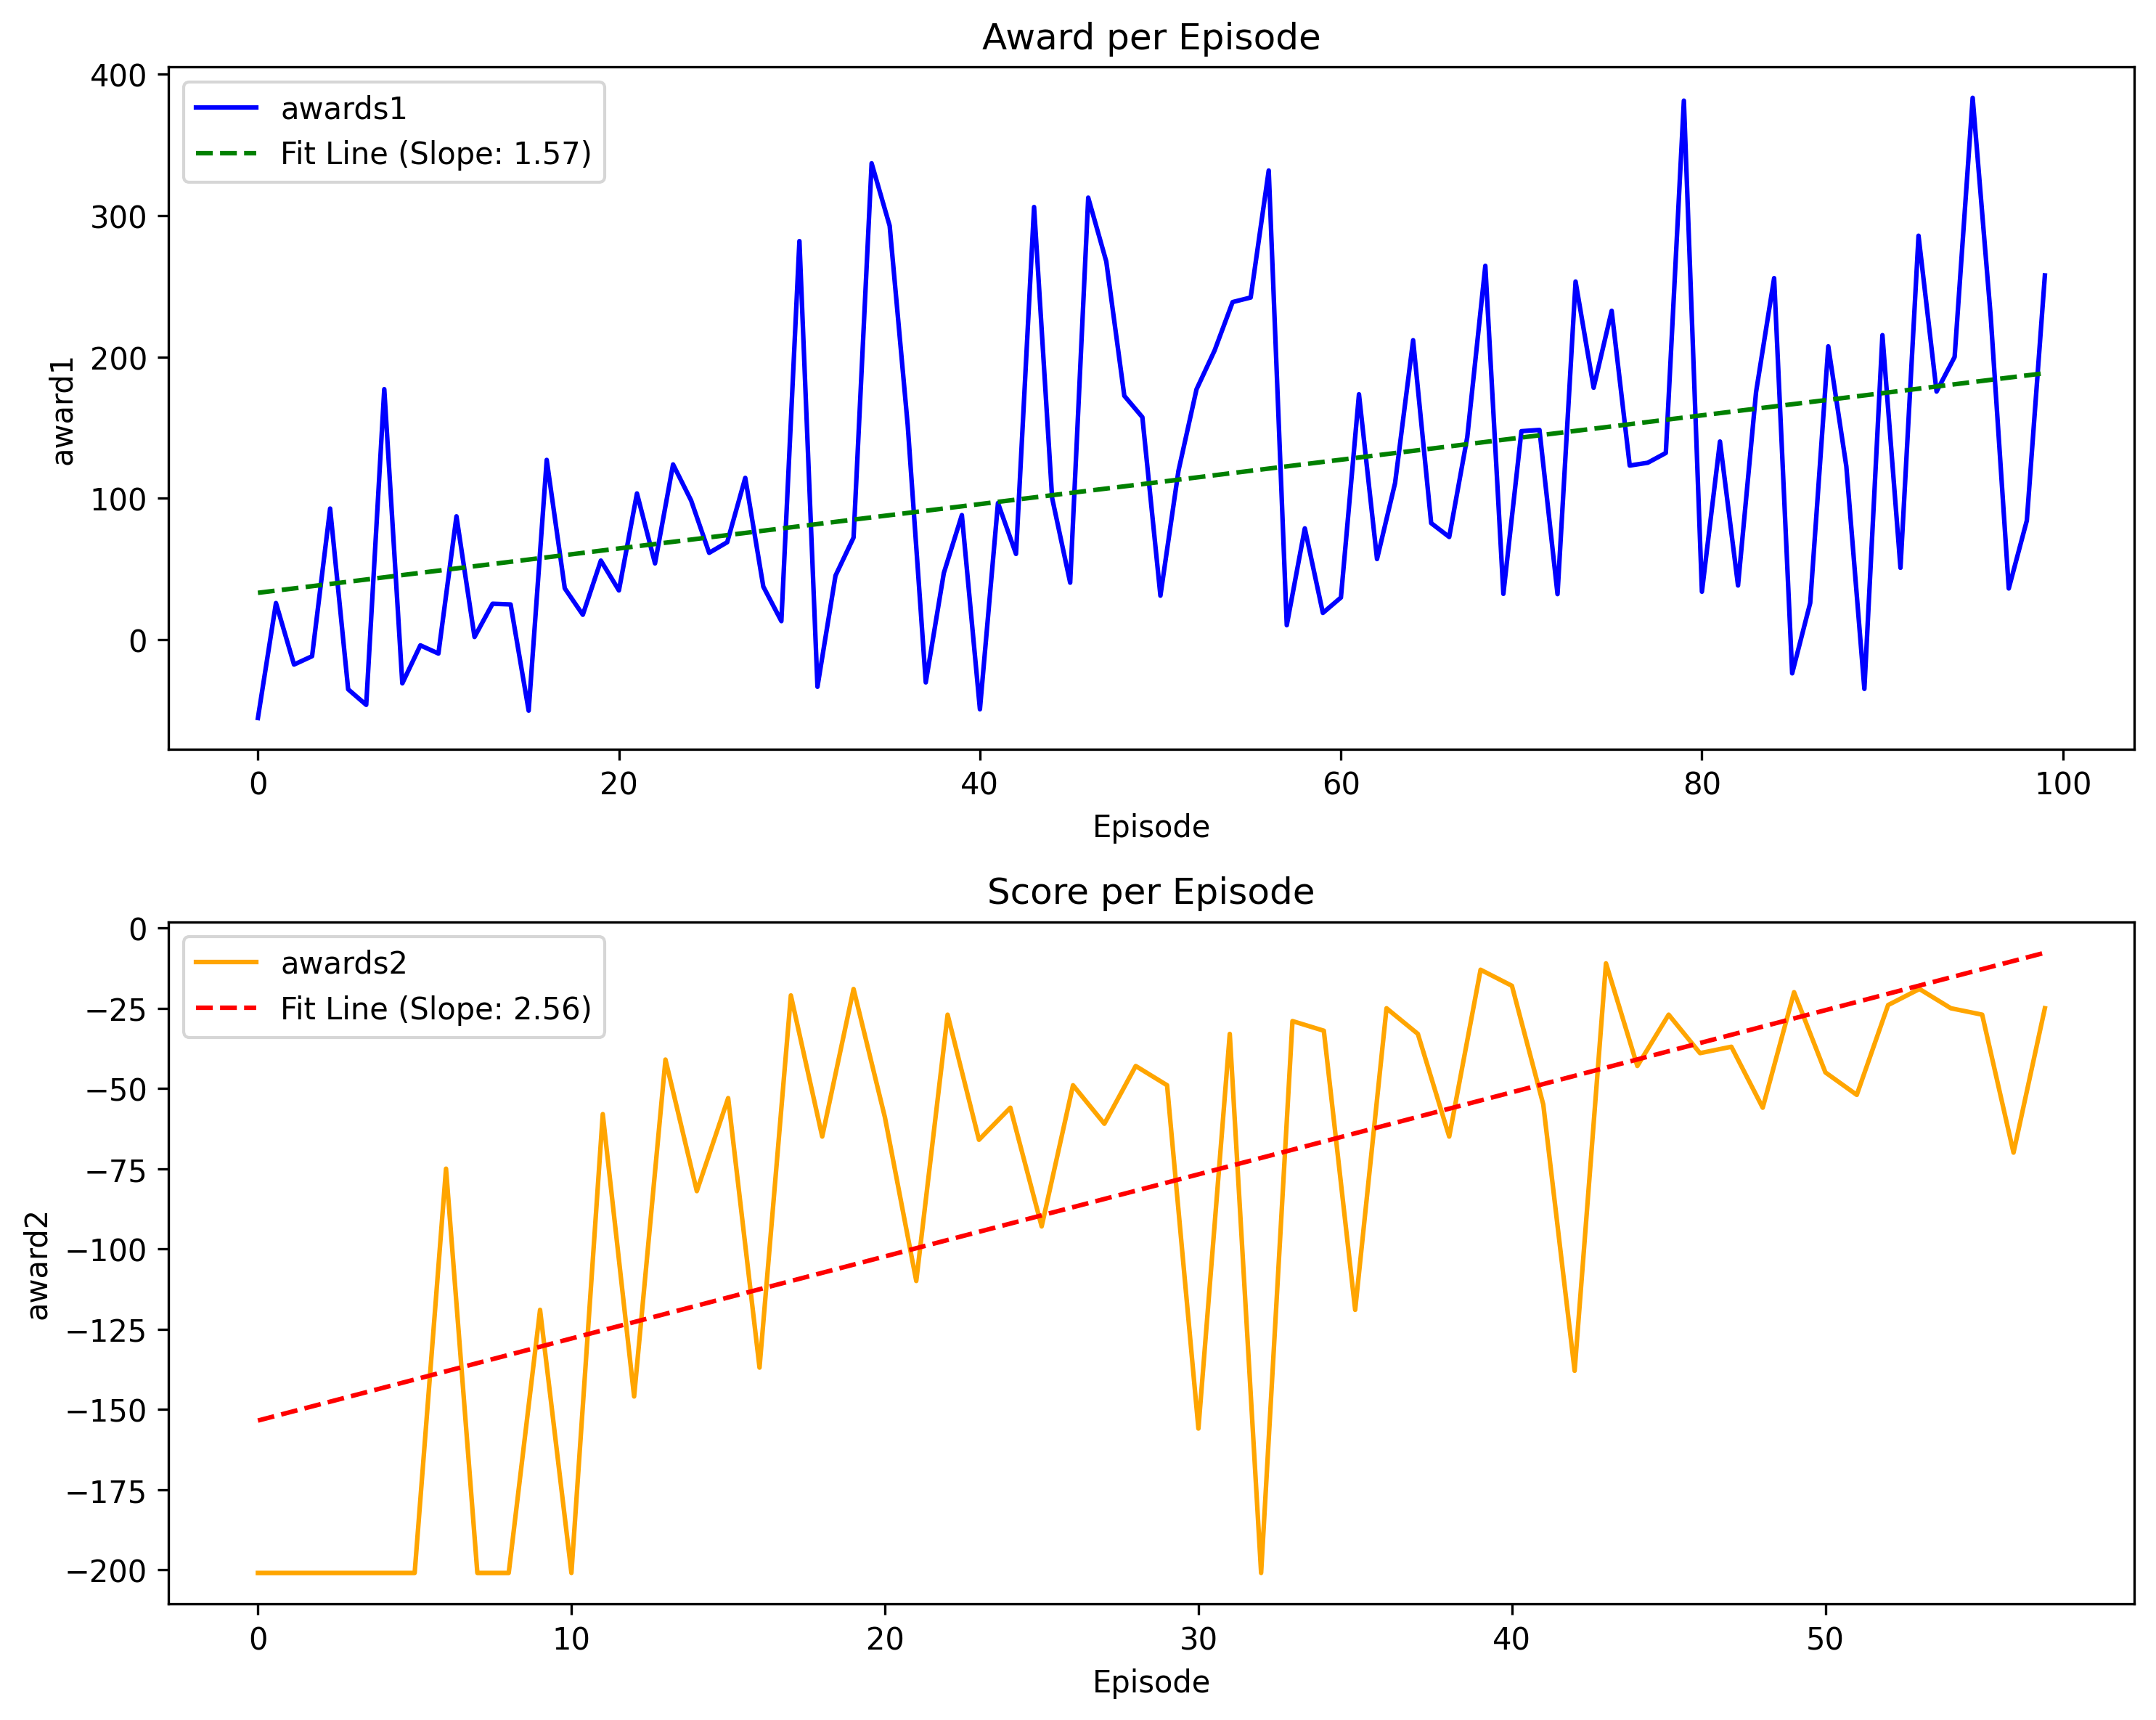

In [23]:
import matplotlib.pyplot as plt
import numpy as np
awards1 = [t[0] for t in new_result]
awards2=[-201, -201, -201, -201, -201, -201, -75, -201, -201, -119, -201, -58, -146, -41, -82, -53, -137, -21, -65, -19, -59, -110, -27, -66, -56, -93, -49, -61, -43, -49, -156, -33, -201, -29, -32, -119, -25, -33, -65, -13, -18, -55, -138, -11, -43, -27, -39, -37, -56, -20, -45, -52, -24, -19, -25, -27, -70, -25]

plt.rcParams['figure.dpi'] = 300

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
x1 = np.arange(len(awards1))
axes[0].plot(x1, awards1, label='awards1', color='blue')

slope1, intercept1 = np.polyfit(x1, awards1, 1)
fit_line1 = slope1 * x1 + intercept1
axes[0].plot(x1, fit_line1, label=f'Fit Line (Slope: {slope1:.2f})', color='green', linestyle='--')

axes[0].set_title('Award per Episode')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('award1')
axes[0].legend()

x2 = np.arange(len(awards2))
axes[1].plot(x2, awards2, label='awards2', color='orange')

slope2, intercept2 = np.polyfit(x2, awards2, 1)
fit_line2 = slope2 * x2 + intercept2
axes[1].plot(x2, fit_line2, label=f'Fit Line (Slope: {slope2:.2f})', color='red', linestyle='--')

axes[1].set_title('Score per Episode')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('award2')
axes[1].legend()

plt.tight_layout()
plt.savefig('line plot.png')
plt.show()

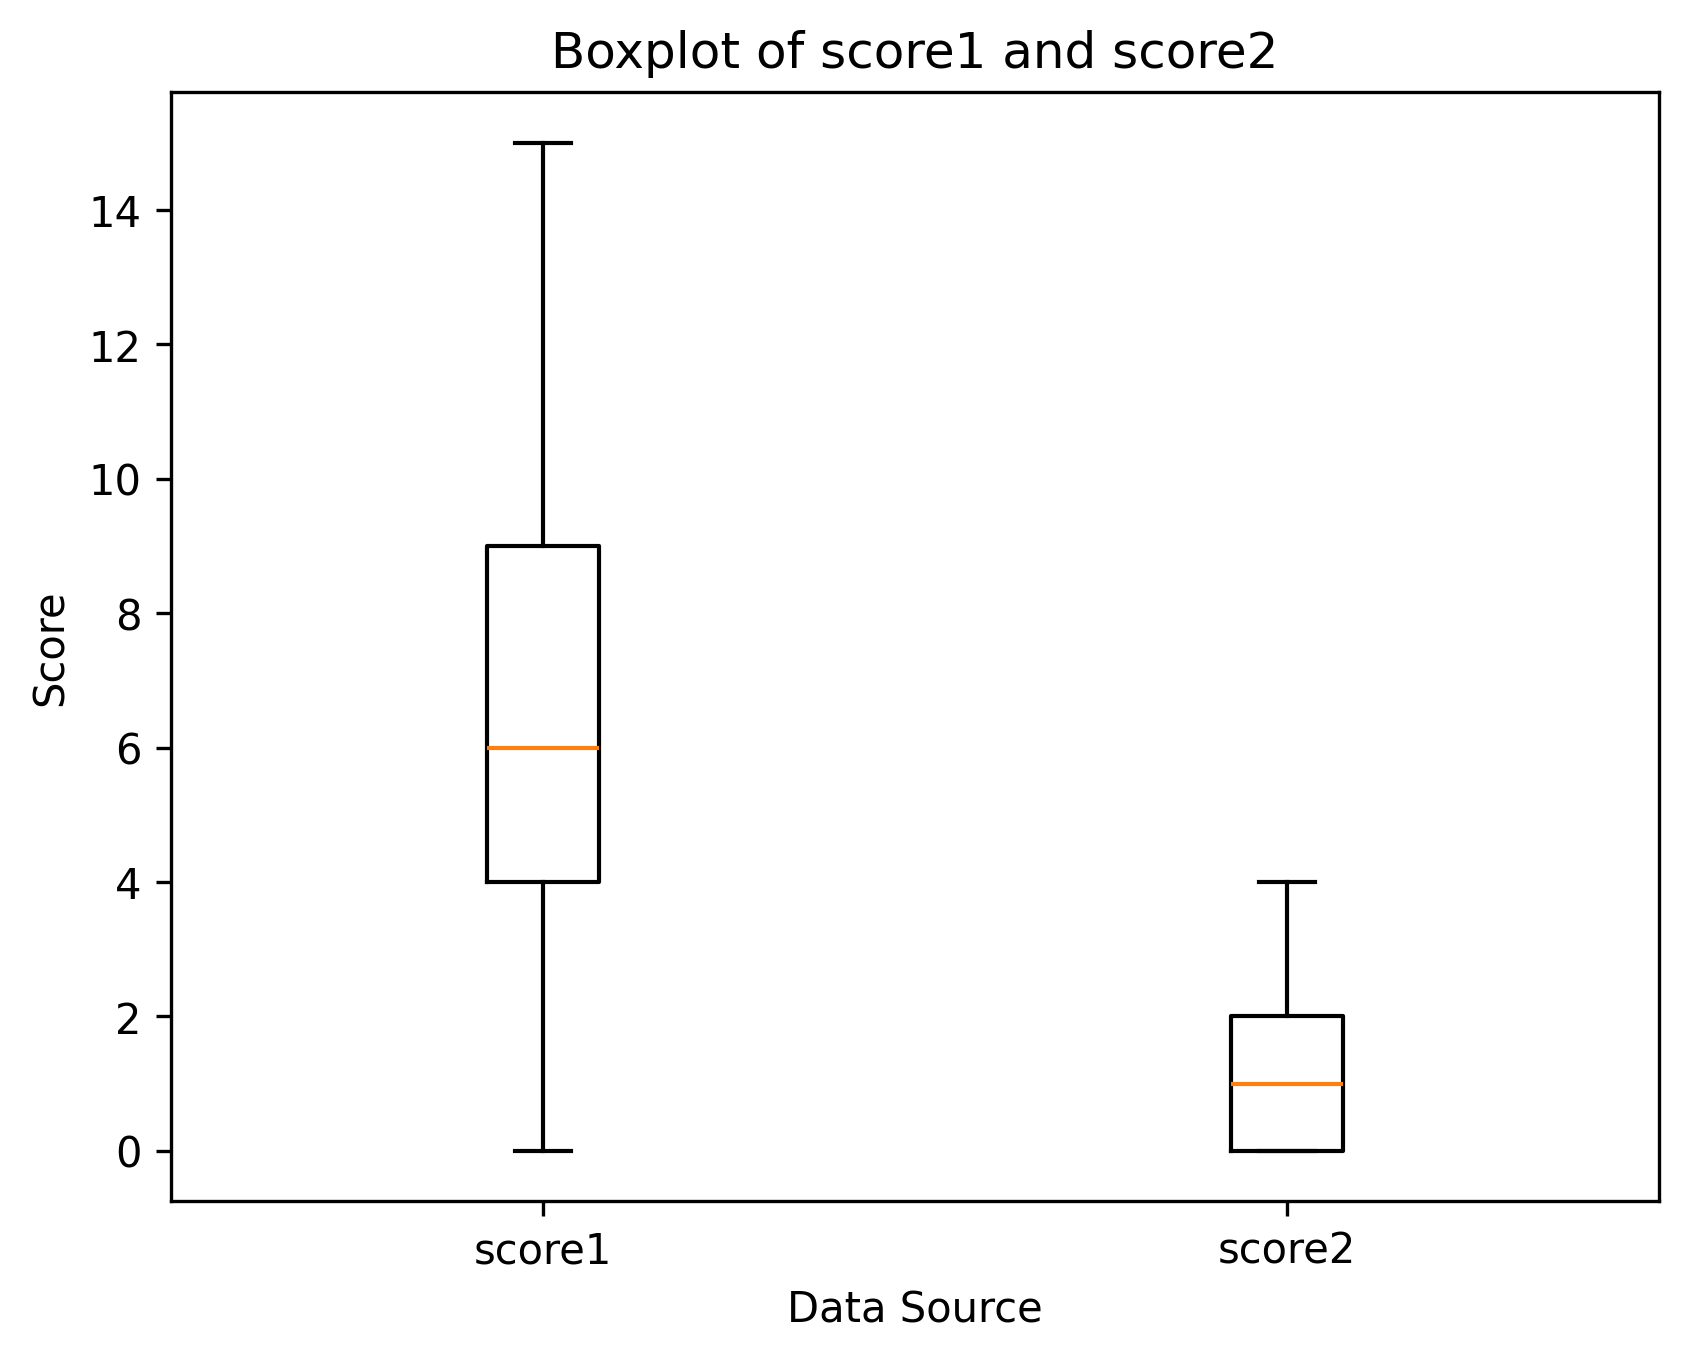

In [21]:
import matplotlib.pyplot as plt
import numpy as np
score1 = [t[1] for t in new_result]
score2=[0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 3, 0, 2, 2, 2, 1, 3, 1, 3, 0, 0, 1, 3, 0, 3, 4, 1, 3, 1, 3, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 3, 3, 0, 1, 1, 1, 0, 2, 1]
data = [score1, score2]

plt.boxplot(data, tick_labels=['score1', 'score2'])

plt.title('Boxplot of score1 and score2')
plt.xlabel('Data Source')
plt.ylabel('Score')
plt.savefig('box_plot.png')
plt.show()